## Demonstration of layer sharing on LeNet-5

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

Parameters

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH =  os.path.join(PATH_PREFIX, 'models/lenet/saves/lenet_tanh.save')
SAVE_DATA = os.path.join(PATH_PREFIX, 'results/test_share.csv')

Setting up the components

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, 'tanh')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Getting the network

In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

In [6]:
lam_test()

0.9864

In [7]:
#ws_controller.share_total(10, 1, 1, plot=True, assign=True)

<Figure size 640x480 with 0 Axes>

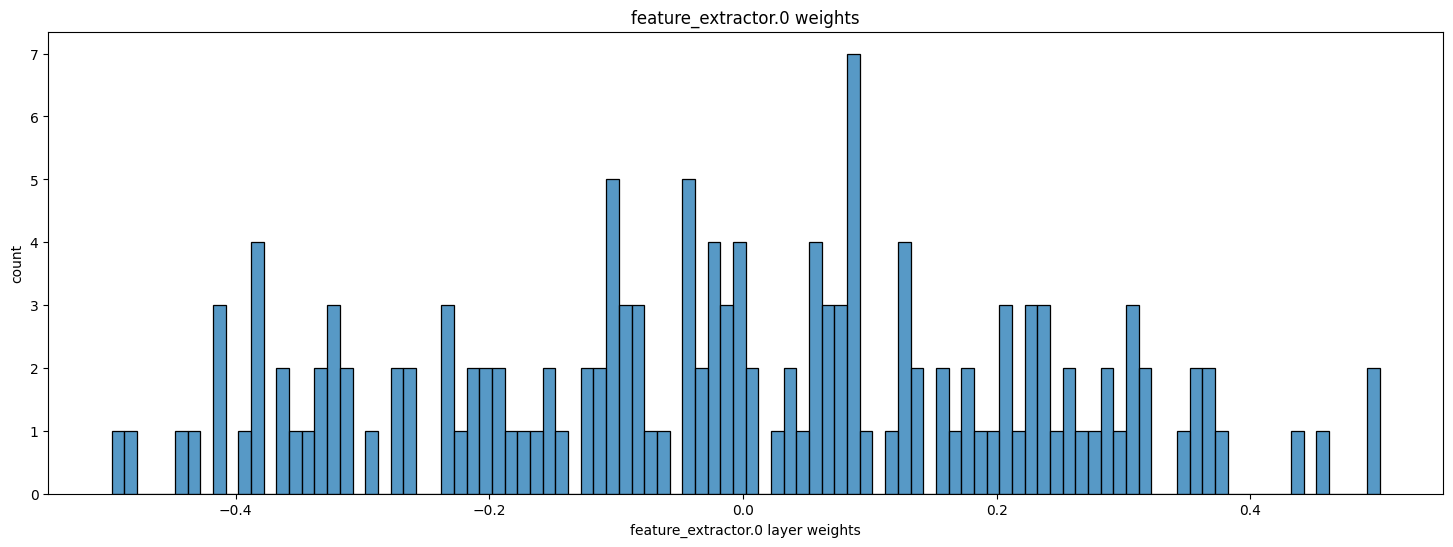

In [8]:
#sns.set(font_scale=1.5, style='white')
ws_controller.model_layers[0].plot_weight()

In [9]:
#ws_controller.model_layers[4].share_weight(5, plot=True, mod_focus=2, mod_spread=1)
#plt.savefig('./results/plots/layer_kmeans.pdf')

TEST - Sharing the whole network to given parameters

In [10]:

ws_controller.share([4, 4, 7, 10, 4], verbose=True, minibatch_kmeans=True)

# u tanh lenetu
# mods=[0, 0, 0, 0, 0] 'accuracy': 0.9738
# mods=[2, 2, 2, 2, 2] 'accuracy': 0.9808,

# cr 11.98956930434724

# share time kmeans - 0.8162627220153809 acc - 0.9738
# share time minibatchkmeans - 0.22685647010803223 acc - 0.977

Share: 1/5 ---  Time: 0.04s	 Name: feature_extractor.0	Before params: 150	 After params: 4	
Share: 2/5 ---  Time: 0.03s	 Name: feature_extractor.3	Before params: 2400	 After params: 4	
Share: 3/5 ---  Time: 0.03s	 Name: feature_extractor.6	Before params: 48000	 After params: 7	
Share: 4/5 ---  Time: 0.03s	 Name: classifier.0	Before params: 10080	 After params: 10	
Share: 5/5 ---  Time: 0.02s	 Name: classifier.2	Before params: 840	 After params: 4	


{'accuracy': 0.977,
 'compression': 11.98956930434724,
 'inertias': [0.6739406585693359,
  4.880798816680908,
  7.325132369995117,
  2.1700026988983154,
  4.560333251953125],
 'times': {'train': 0,
  'share': 0.15051960945129395,
  'test': 1.0472519397735596}}

<Figure size 640x480 with 0 Axes>

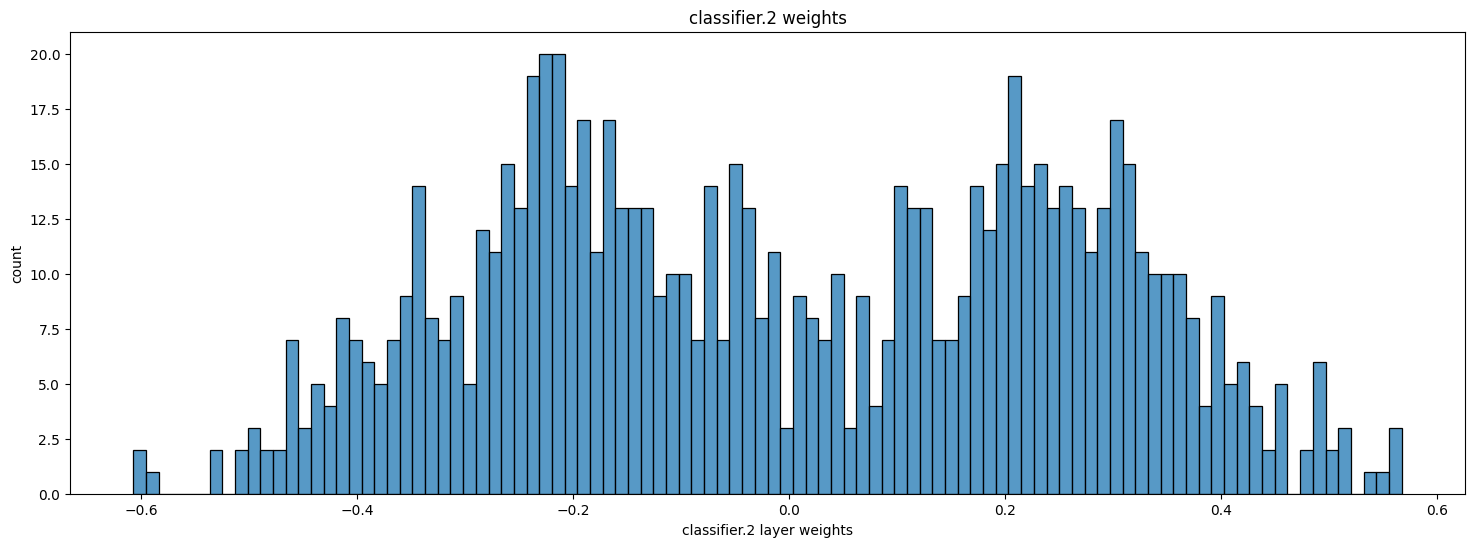

In [15]:
ws_controller.model_layers[4].plot_weight()

Setting scoring functions

In [ ]:
before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)
lam_score2 = lambda layer : layer.compression_rate()
lam_score3 = lambda _ : (get_accuracy(model, dataset.test_dl, DEVICE) + get_accuracy(model, dataset.valid_dl, DEVICE)\
    + get_accuracy(model, dataset.train_dl, DEVICE)) / 3 

TEST - sharing whole network with pre score-functions

In [ ]:
"""
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)

def pre_perf(layer):
    opt = lam_opt(model)
    lam_train(opt, 1)

ws_controller.get_layer_cluster_nums_perf(1, range(10,20), [lam_score1, lam_score2], pre_perf)
ws_controller.get_layer_cluster_nums_perf(1, range(10,100), [lam_score1, lam_score2])
"""

Getting optimal num of clusters for a given layer

In [ ]:
data = {
    'num clusters': [],
    'accuracy': [],
    'layer': []
}

data_types = {
    'num clusters': 'int16',
    'accuracy': 'float32',
    'layer': 'uint8'
}

share_data = pd.DataFrame(data).astype(data_types)

for layer in [0, 4]:
    scores = ws_controller.get_layer_cluster_nums_perf(layer, range(2,3), [lam_score1])
    
    for item in scores:
        share_data = share_data.append({
            'num clusters': item[0],
            'accuracy loss': (before_loss - item[1][0]),
            'layer': layer,
        }, ignore_index=True).astype(data_types)

share_data.to_csv(SAVE_DATA, index=False)

Pot data

In [ ]:
plot_alncl(share_data)

After measurements the net is not changed

In [ ]:
ws_controller.print_layers_info()

In [ ]:
layer_ranges = [range(1, 10), range(1, 10), range(1, 10), range(1, 10), range(1, 10)]
lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller.get_optimized_layer_ranges(layer_ranges, lam_score1, 0.98, savefile=os.path.join(PATH_PREFIX, 'results/lol.csv'))